This is an implementation of an extremely simple NN intended only to predict the contents of a tile given no other information to leverage.

# Import Modules and Run Dependencies

## Data Loaders and Handlers

In [1]:
%run './Loading Dataset and Preprocess.ipynb'

In [2]:
import numpy as np
import torch  # pytorch for neural network
from matplotlib import pyplot as plt  # basic plotting

## Modules

# Define Fully Connected Neural Network

## Network Architecture

In [113]:
# Currently has 2 hidden layers of size 50

# possible labels: (B, W) X (K,Q,R,N,P,B) + E \in P^{13}
# probability vector of length 13
class FullyConnectedNN(torch.nn.Module):

    def __init__(self, image_dims, learning_rate=.1, momentum=0.9):
        super(FullyConnectedNN, self).__init__()
        color = len(image_dims) == 3
        self.model = torch.nn.Sequential(
            torch.nn.Linear(np.product(image_dims), 50),
            torch.nn.Sigmoid(),
            torch.nn.Linear(50, 13)
        )
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(),
                                         lr=learning_rate,
                                         momentum=momentum)

    def forward(self, x):
        return torch.softmax(self.model(x), dim=1)

    def get_loss(self, X, Y):
        out = self.model(X)
        return self.criterion(out, Y)
    
    def predict(self, X):
        probs = torch.nn.Softmax(dim=1)(self.forward(X))
        return torch.argmax(X, dim=1)

In [114]:
def prepare_batch_for_FCNN(batch, label_index):
    """Prepare a batch for the NN"""
    tiles = tileify(*batch)
    X = []
    Y = []
    for tile in tiles:
        X.append(tile.image)
        Y.append(label_index.index(
            tile.piece_color + tile.piece_label))
    return torch.Tensor(X).view(
        -1, np.product(tile_size) * 3).float(), torch.Tensor(Y).long()

# Demonstration

Here, we will demonstrate the usage of this network.

In [115]:
from itertools import repeat

In [116]:
nbatches = 10
color = True
resize = 80, 80
sample_size = 1  # sample size for training
progress_sample_index = np.arange(300)

original_size = 400, 400

tile_size = np.array(resize) // (8, 8)

label_index = [a + b for a in 'WB' for b in 'KQRNPB'] + ['']
# possible labels: (B, W) X (K,Q,R,N,P,B) + E \in P^{13}

network = FullyConnectedNN(
    (*tile_size, 3)
)

indexset = np.arange(sample_size)


In [117]:
optimizer = network.optimizer
epochs = []

In [121]:
# define function to track progress
def progress(net):
    # run on sample of test set
    correct_train = 0
    loss_train = 0
    n_train = 0
    correct_test = 0
    loss_test = 0
    n_test = 0
    
    # test accuracy
    for X, Y in map(prepare_batch_for_FCNN,
                    batched_load(test=True, count=len(progress_sample_index),
                                 color=color, dsize=resize, batchsize=100,
                                 idxset=progress_sample_index),
                    repeat(label_index)
                   ):
        preds = network.predict(X).numpy()
        true = Y.numpy()
        correct_test += (preds == true).sum()
        n_test += len(true)
        loss_test += network.get_loss(X, Y).item() * len(X)
        
    # train accuracy
    for X, Y in map(prepare_batch_for_FCNN,
                    batched_load(test=False, count=len(indexset),
                                 color=color, dsize=resize, batchsize=100,
                                 idxset=indexset),
                    repeat(label_index)
                   ):
        preds = network.predict(X).numpy()
        true = Y.numpy()
        correct_train += (preds == true).sum()
        n_train += len(true)
        loss_train += network.get_loss(X, Y).item() * len(X)
        
    # save results
    epochs.append((
        correct_train / n_train,  # train accuracy
        correct_test / n_test,  # test accuracy
        loss_train / n_train,  # training loss
        loss_test / n_test,  # testing loss
    ))
    
    print(f'\nepoch {len(epochs)} finished.')
    if (len(epochs) - 1) % 10 == 0 or True:
        plt.title('Progress (test and train accuracy)')
        for series in np.array(epochs).T:
            plt.plot(series)
        plt.legend([
            'train accuracy', 'test accuracy',
            'train loss', 'test loss'
        ])
        plt.show()
#progress(network)

-461.254638671875
batch 0
epoch 21 finished.


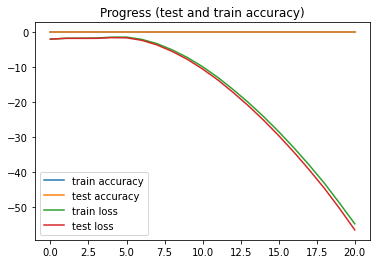

-517.056884765625
batch 0
epoch 22 finished.


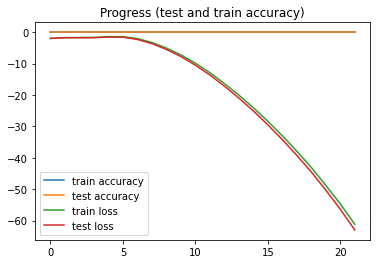

-573.65673828125


KeyboardInterrupt: 

In [122]:
#epochs = []
for epochi in range(10):
    for i, (X, Y) in enumerate(#enumerate(range(1))):
        map(prepare_batch_for_FCNN,
            batched_load(count=sample_size, color=True, dsize=resize,
                            batchsize=3000, idxset=indexset),
            repeat(label_index))):
        X = torch.Tensor(
            np.concatenate((
                np.ones((400, np.product(tile_size) * 3)),
                np.zeros((400, np.product(tile_size) * 3))
            ), axis=0)
        ).float()
        Y = torch.Tensor(
            np.concatenate((
                np.ones(400),
                np.zeros(400)
            ), axis=0)
        ).long()
        optimizer.zero_grad()
        loss = network.get_loss(X, Y)
        loss.backward()
        print(loss.item())
        optimizer.step()
        print(f'batch {i}', end='\r')
        
    progress(network)

In [124]:
np.array(epochs).T[:2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.00161458, 0.00161458, 0.00161458, 0.00161458, 0.00161458,
        0.00161458, 0.00161458, 0.00161458, 0.00161458, 0.00161458,
        0.00161458, 0.00161458, 0.00161458, 0.00161458, 0.00161458,
        0.00161458, 0.00161458, 0.00161458, 0.00161458, 0.00161458,
        0.00161458, 0.00161458]])